<a href="https://colab.research.google.com/github/hrnnikolov/ML_models/blob/main/pytorch_classification_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [367]:
#import sklearn

In [368]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=33)

In [369]:
X[0:5]

array([[-0.92631372, -0.44504141],
       [ 0.34889196, -0.92585137],
       [-0.90612188, -0.02167732],
       [ 1.05520498,  0.01292639],
       [ 0.00257544, -1.00524639]])

In [370]:
import pandas as pd

circles = pd.DataFrame({'X1': X[:,0],
                        'X2': X[:,1],
                        'label': y})
circles

,X1,X2,label
0,-0.926314,-0.445041,0
1,0.348892,-0.925851,0
2,-0.906122,-0.021677,0
3,1.055205,0.012926,0
4,0.002575,-1.005246,0
...,...,...,...
995,-0.346955,0.764172,1
996,0.474477,0.642467,1
997,-0.778041,0.144401,1
998,0.241981,-0.984062,0


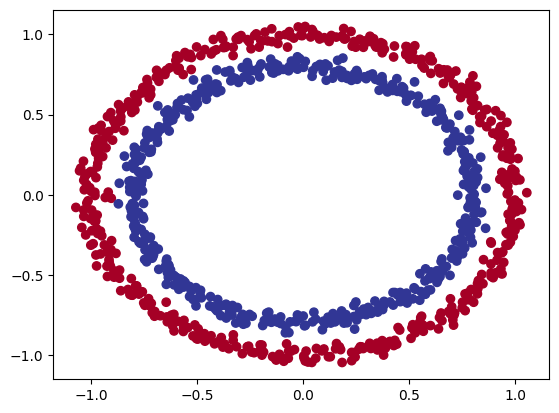

In [371]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [372]:
X.shape, y.shape

((1000, 2), (1000,))

In [373]:
import torch
torch.__version__

'2.1.0+cu121'

In [374]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [375]:
X[:5]

tensor([[-0.9263, -0.4450],
        [ 0.3489, -0.9259],
        [-0.9061, -0.0217],
        [ 1.0552,  0.0129],
        [ 0.0026, -1.0052]])

In [376]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33, test_size=0.2)

In [377]:
X_train.shape

torch.Size([800, 2])

In [378]:
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [379]:
class CircleModel(nn.Module):
  def __init__(self) :
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))

model_0 = CircleModel().to(device)
model_0


CircleModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [380]:
loss_fn = nn.BCEWithLogitsLoss() # this got sigmoid actv fn build in
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

In [381]:
# calc accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [382]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.6376],
        [-0.6033],
        [-0.3542],
        [-0.1467],
        [-0.5804]], device='cuda:0')

In [383]:
y_test[:5]

tensor([1., 1., 0., 0., 1.])

In [384]:
#logits to probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3458],
        [0.3536],
        [0.4124],
        [0.4634],
        [0.3588]], device='cuda:0')

In [385]:
y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
torch.eq(y_preds.squeeze(), y_pred_labels.squeeze())

tensor([True, True, True, True, True], device='cuda:0')

In [386]:
y_preds.squeeze()

tensor([0., 0., 0., 0., 0.], device='cuda:0')

In [387]:
epochs = 500

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()


  #testing
  model_0.eval()

  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  if epoch % 10 ==0:
    print(f'Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test_Loss: {test_loss:.5f} | Test_Acc: {test_acc:.2f}%')


Epoch: 0 | Loss: 0.71879 | Acc: 49.62% | Test_Loss: 0.71499 | Test_Acc: 51.50%
Epoch: 10 | Loss: 0.71628 | Acc: 49.62% | Test_Loss: 0.71295 | Test_Acc: 51.50%
Epoch: 20 | Loss: 0.71402 | Acc: 49.62% | Test_Loss: 0.71113 | Test_Acc: 51.50%
Epoch: 30 | Loss: 0.71200 | Acc: 49.62% | Test_Loss: 0.70952 | Test_Acc: 51.50%
Epoch: 40 | Loss: 0.71018 | Acc: 49.62% | Test_Loss: 0.70809 | Test_Acc: 51.50%
Epoch: 50 | Loss: 0.70855 | Acc: 49.62% | Test_Loss: 0.70682 | Test_Acc: 51.50%
Epoch: 60 | Loss: 0.70709 | Acc: 49.62% | Test_Loss: 0.70569 | Test_Acc: 51.50%
Epoch: 70 | Loss: 0.70577 | Acc: 49.38% | Test_Loss: 0.70469 | Test_Acc: 51.50%
Epoch: 80 | Loss: 0.70459 | Acc: 48.12% | Test_Loss: 0.70380 | Test_Acc: 48.50%
Epoch: 90 | Loss: 0.70353 | Acc: 45.12% | Test_Loss: 0.70302 | Test_Acc: 44.50%
Epoch: 100 | Loss: 0.70258 | Acc: 43.75% | Test_Loss: 0.70232 | Test_Acc: 42.50%
Epoch: 110 | Loss: 0.70173 | Acc: 41.25% | Test_Loss: 0.70171 | Test_Acc: 41.00%
Epoch: 120 | Loss: 0.70096 | Acc: 41.00

In [388]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
  print('helper_functions.py already exists')
else:
  print('Downloading helper_functions.py')
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)

helper_functions.py already exists


In [389]:
from helper_functions import plot_predictions, plot_decision_boundary

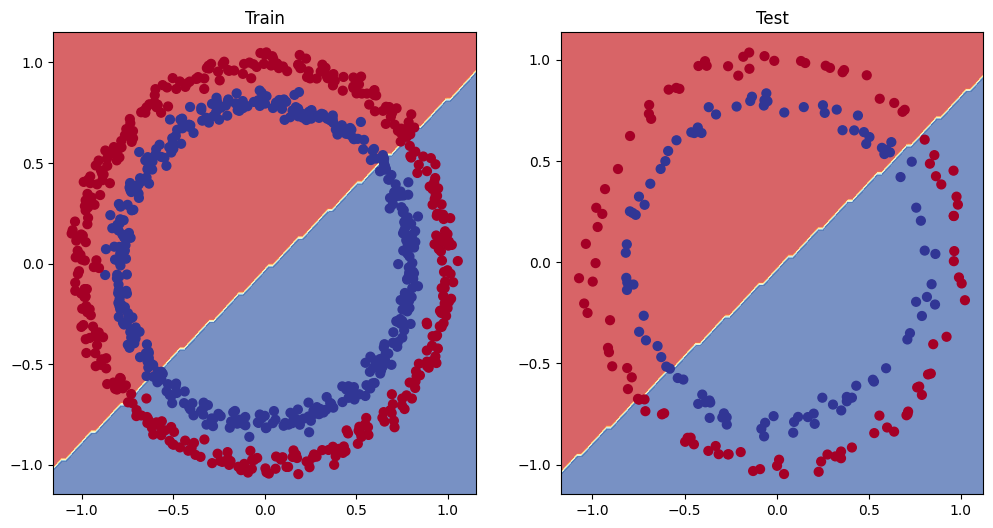

In [390]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2) # rows , cols , index
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

In [391]:
class CircleModelV1(nn.Module):
  def __init__(self) :
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [392]:
loss_fn = nn.BCEWithLogitsLoss() # this got sigmoid actv fn build in
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [393]:
epochs = 3000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

  model_1.train()

  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()


  #testing
  model_1.eval()

  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  if epoch % 100 ==0:
    print(f'Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test_Loss: {test_loss:.5f} | Test_Acc: {test_acc:.2f}%')


Epoch: 0 | Loss: 0.69495 | Acc: 46.75% | Test_Loss: 0.69362 | Test_Acc: 48.00%
Epoch: 100 | Loss: 0.69263 | Acc: 50.25% | Test_Loss: 0.69241 | Test_Acc: 50.50%
Epoch: 200 | Loss: 0.69081 | Acc: 54.25% | Test_Loss: 0.69085 | Test_Acc: 55.00%
Epoch: 300 | Loss: 0.68858 | Acc: 58.25% | Test_Loss: 0.68879 | Test_Acc: 58.00%
Epoch: 400 | Loss: 0.68556 | Acc: 56.25% | Test_Loss: 0.68599 | Test_Acc: 55.50%
Epoch: 500 | Loss: 0.68175 | Acc: 56.75% | Test_Loss: 0.68224 | Test_Acc: 56.50%
Epoch: 600 | Loss: 0.67643 | Acc: 57.88% | Test_Loss: 0.67685 | Test_Acc: 56.50%
Epoch: 700 | Loss: 0.66824 | Acc: 62.88% | Test_Loss: 0.66854 | Test_Acc: 63.00%
Epoch: 800 | Loss: 0.65509 | Acc: 71.12% | Test_Loss: 0.65510 | Test_Acc: 71.00%
Epoch: 900 | Loss: 0.63413 | Acc: 83.50% | Test_Loss: 0.63354 | Test_Acc: 82.00%
Epoch: 1000 | Loss: 0.59877 | Acc: 88.38% | Test_Loss: 0.59723 | Test_Acc: 90.50%
Epoch: 1100 | Loss: 0.54191 | Acc: 92.88% | Test_Loss: 0.53806 | Test_Acc: 93.50%
Epoch: 1200 | Loss: 0.45172 

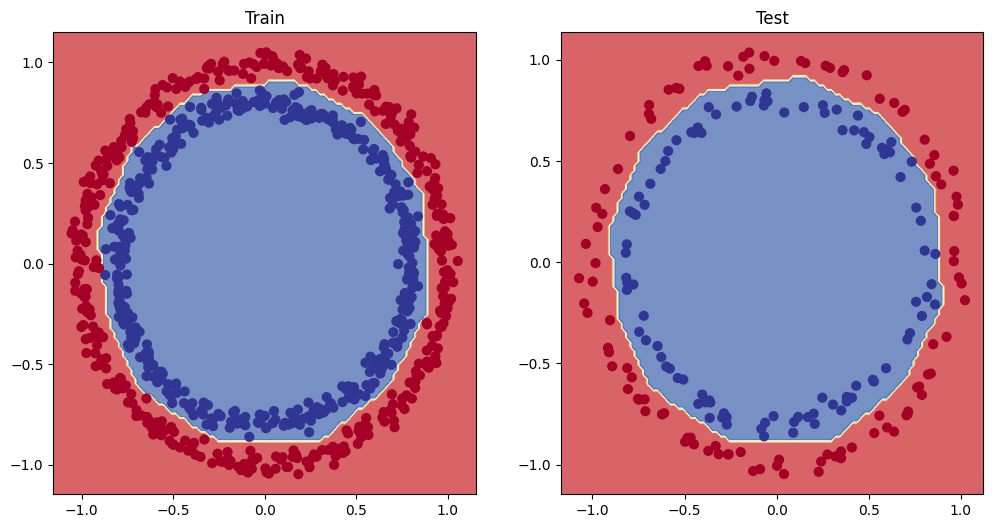

In [394]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2) # rows , cols , index
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)